## Causal Effect Estimation of the Arctic Sea Ice Dataset Using Dimensional Causality (DC) and Conditional Instrumental variable (CIV)

In this notebook, we will see how can we estimate the causal effect from observational data and causal graph using Dimensional Causality (DC) method.

Here are the steps that will be involved in this notebook.
1. Install and load necessary libraries
2. Read the dataset and visualization
3. Causal effect estimation using Dimensional Causality (DC)
4. Causal effect estimation using Conditional Instrumental variable (CIV)

---
1. Install and load necessary libraries
---

In [ ]:
!pip install git+https://github.com/adam-zlatniczki/dimensional_causality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/adam-zlatniczki/dimensional_causality to /tmp/pip-req-build-8y3z523m
  Running command git clone -q https://github.com/adam-zlatniczki/dimensional_causality /tmp/pip-req-build-8y3z523m
  Created wheel for Dimensional-Causality: filename=Dimensional_Causality-1.0-py3-none-any.whl size=841869 sha256=67a87891e8bd8a5f45f6aeb84f726c6e87bca90e813e0d8a75b341e0f39d9fe5
  Stored in directory: /tmp/pip-ephem-wheel-cache-g5d3s2qa/wheels/9a/71/ad/fb00a79cad1c63f0c7209e48dbfbf7210bba238495afb317b5
Successfully built Dimensional-Causality


In [ ]:
!apt-get install g++
!apt-get install make

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
make is already the newest version (4.1-9.1ubuntu1).
make set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


---
2. Read the dataset and visualizatio
---
To read the dataset from Google Drive we need to mount the google drive in the Colab notebook. Then read Arctic Sea Ice daily data from the year 1979 to 2021. This dataset has 15584 rows × 11 columns for Arctic Sea Ice. The values of the sst, snowfall, and sea_ice_extent variables are plotted using a line graph. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
sea_ice_daily = pd.read_csv('/content/drive/MyDrive/CA-ML-Project/Data/Arctic_domain_mean_1979_2021.csv')

In [ ]:
sea_ice_daily

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1979-01-01,5.872050,0.786595,184.999071,1.417925,1.089897,1.031549,273.379711,250.401819,979.401142,14997215.0
1,1979-01-02,6.155597,0.756973,182.686318,1.368594,0.923499,0.837877,273.376830,250.364683,979.340886,14997215.0
2,1979-01-03,5.691054,0.777598,186.387764,1.197913,1.218984,1.066028,273.385489,250.452749,983.409060,14997215.0
3,1979-01-04,5.628824,0.819629,191.888081,1.405106,1.783778,1.448627,273.396461,250.290579,983.557055,14922219.0
4,1979-01-05,6.255928,0.869896,190.541890,1.305893,0.995828,0.776768,273.404602,250.895886,978.020927,14922219.0
...,...,...,...,...,...,...,...,...,...,...,...
15579,2021-08-27,5.386638,4.563584,305.197693,102.101318,2.559692,0.388835,278.514526,278.483246,980.477173,5279000.0
15580,2021-08-28,5.234190,4.366545,302.980530,102.355118,1.951954,0.489219,278.515076,277.969543,981.036499,5268000.0
15581,2021-08-29,4.675841,4.300599,302.045685,98.769402,1.618767,0.333258,278.482941,277.669586,981.798767,5189000.0
15582,2021-08-30,4.396615,4.272134,300.618896,99.093216,1.643894,0.335707,278.492828,277.581635,983.147156,5157000.0


In [ ]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline

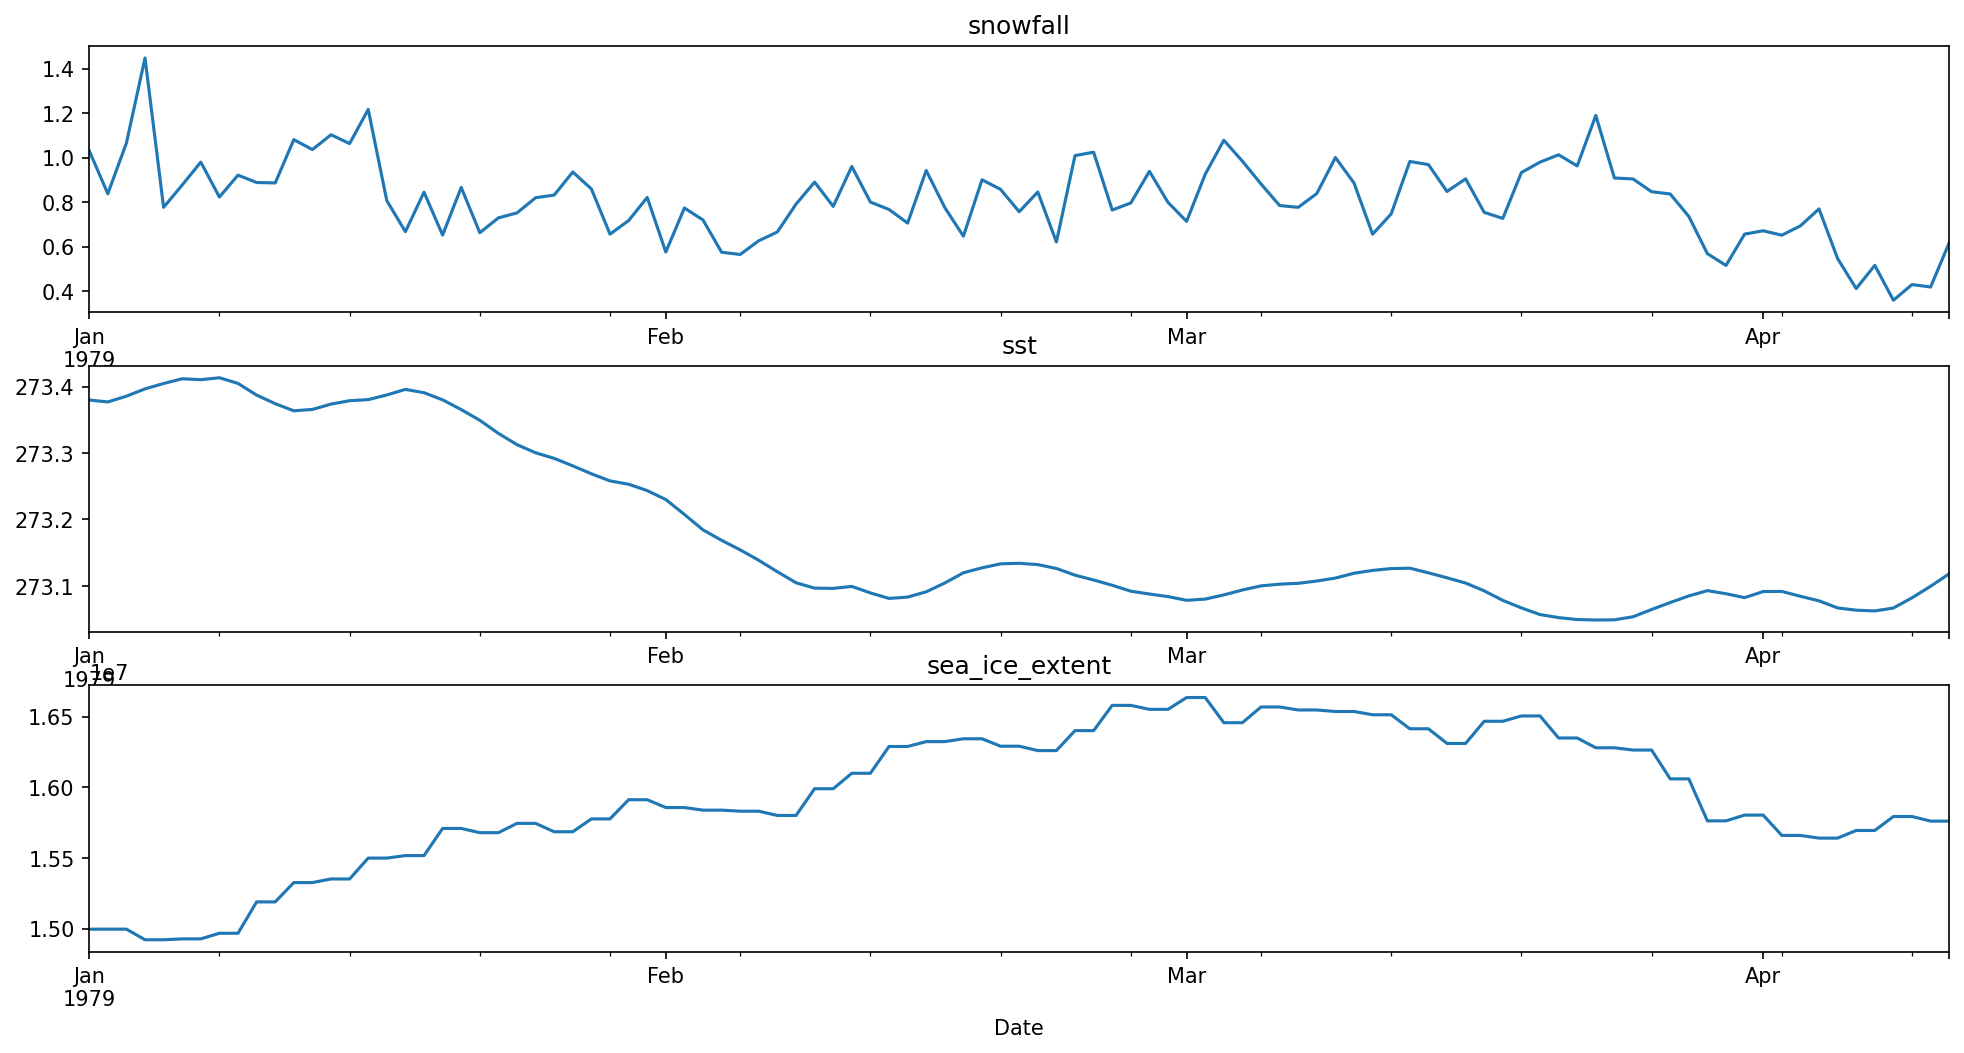

In [ ]:
sea_ice_daily_vis = pd.read_csv('/content/drive/MyDrive/CA-ML-Project/Data/Arctic_domain_mean_1979_2021.csv', 
                                index_col='Date', parse_dates=True)
var_name = ['snowfall', 'sst', 'sea_ice_extent']
sea_ice_features = sea_ice_daily_vis.iloc[:101,:]
plt.figure(figsize=(16, 8), dpi=150)
plt.title('Arctic Sea Ice Data 1979-2021')
plt.xlabel('Months')
plt.legend()
for i in range(3):
    ax= plt.subplot(3, 1, i + 1)
    sea_ice_features[var_name[i]].plot(label=var_name[i])
    ax.set_title(var_name[i])



---
3. Causal effect estimation using Dimensional Causality (DC)
---
To measure the strength of the causal relationship using the DC method we have to provide the cause variable in parameter X, the effect variable in parameter Y, the number of embedded dimensions in emd_dim, and the time delay in parameter tau of the infer_causality function. The function will generate the graph with the estimated strength of each relationship direction between the cause and effect variable.

### Causal effect of "sst->sea_ice_extent" (by DC)

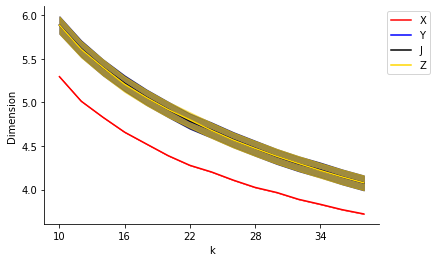

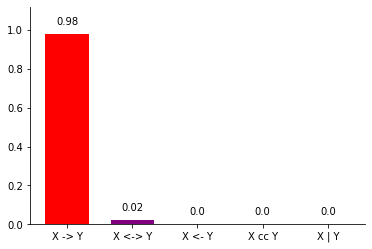

[0.984510449280099,
 0.015419043206980258,
 5.761624292286035e-07,
 3.358723250831779e-05,
 3.634411798321445e-05]

In [ ]:
# sst -> sea_ice_extent

import numpy as np
import dimensional_causality as dc

np.random.seed(0)
x = sea_ice_daily.sst.to_numpy()
y = sea_ice_daily.sea_ice_extent.to_numpy()
k_range = range(10, 40, 2)

#infer_causality(x, y, emb_dim, tau)
probs, dims, stdevs = dc.infer_causality(x, y, 9, 1, k_range)
probs#, dims, stdevs

In [ ]:
#def infer_causality(x, y, emb_dim, tau, k_range, eps=0.05, c=3.0, bins=20.0, downsample_rate=1, export_data=False, plot=True, use_latex=False):

### Causal effect of "snowfall->sea_ice_extent" (by DC)

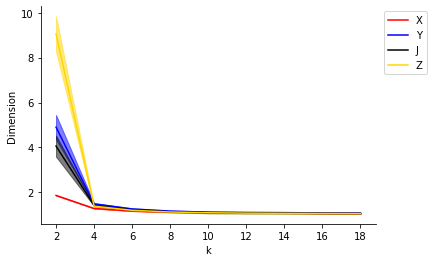

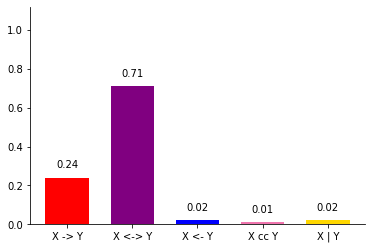

[0.23636771047596236,
 0.7070041641213329,
 0.018532816663670817,
 0.009190266110653234,
 0.028905042628380624]

In [ ]:
## snowfall -> sea_ice_extent

import dimensional_causality as dc

np.random.seed(0)
x_d_snow = sea_ice_daily.snowfall.to_numpy()
y_d_ice_ext = sea_ice_daily.sea_ice_extent.to_numpy()
k_range = range(2, 20, 2)

#def infer_causality(x, y, emb_dim, tau)
probs, dims, stdevs = dc.infer_causality(x_d_snow, y_d_ice_ext, 9, 0, k_range)
probs

### Causal effect of "specific_humidity->sea_ice_extent" (by DC)

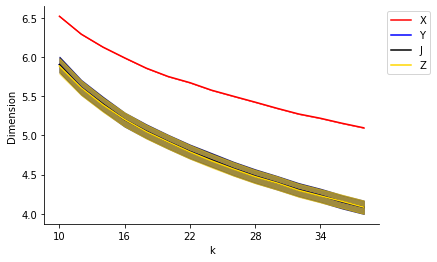

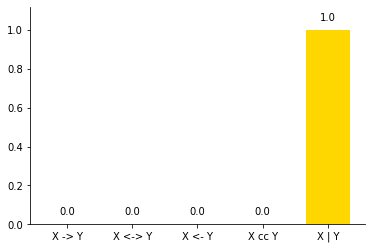

[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
#specific_humidity -> sea_ice_extent

import dimensional_causality as dc

x = sea_ice_daily.specific_humidity.to_numpy()
y = sea_ice_daily.sea_ice_extent.to_numpy()
k_range = range(10, 40, 2)

probs, dims, stdevs = dc.infer_causality(x, y, 9, 1, k_range)
probs

### causal effect of "rainfall->sea_ice_extent" (by DC)

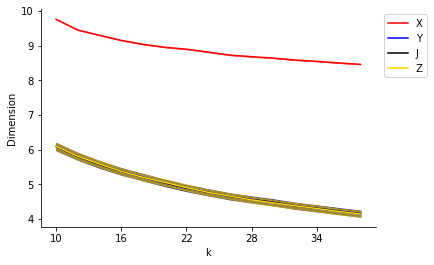

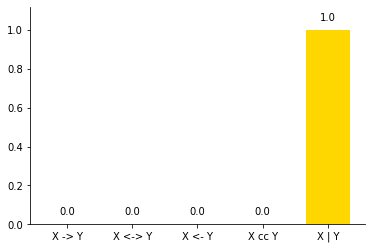

[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
# rainfall -> sea_ice_extent

import dimensional_causality as dc

x = sea_ice_daily.rainfall.to_numpy()
y = sea_ice_daily.sea_ice_extent.to_numpy()
k_range = range(10, 40, 2)

probs, dims, stdevs = dc.infer_causality(x, y, 10, 1, k_range)
probs

---
4. Causal effect estimation using Conditional Instrumental variable (CIV)
---
To use the Conditional Instrumental variable (CIV) method on our dataset first we have to clone the GitHub repository of this method and then change the current path to the cloned directory of the library "its-time". Then we have to define the instrument set I, condition ser B, cause set X, and effect variable Y to measure the causal effect coefficient of X to the Y. 

In [ ]:
import os
import sys

In [ ]:
!git clone https://github.com/nikolajthams/its-time

Cloning into 'its-time'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 55 (delta 12), reused 44 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [ ]:
sys.path.append('/content/its-time')

In [ ]:
#import pandas as pd
from src import var_iv, civ
import numpy as np

### Causal effect of "sst->sea_ice_extent" (by CIV)

In [ ]:
# data = pd.read_csv("example_data.csv")
I = sea_ice_daily[["specific_humidity", "surface_pressure"]]
B = sea_ice_daily[["rainfall"]]
X = sea_ice_daily[["sst"]]
Y = sea_ice_daily["sea_ice_extent"]

In [ ]:
X, Y, I = X.to_numpy(), Y.to_numpy(), I.to_numpy()
B=B.to_numpy()
civ.civ(X=X, Y=Y, I=I, B=B)

array([[72616.72518353]])

### Causal effect of "snowfall->sea_ice_extent" (by CIV)

In [ ]:
# data = pd.read_csv("example_data.csv")
B_1 = sea_ice_daily[["surface_pressure","SW_down"]]
I_1 = sea_ice_daily[["rainfall", "LW_down"]]
X_1 = sea_ice_daily["snowfall"]
Y_1 = sea_ice_daily["sea_ice_extent"]

In [ ]:
X_1, Y_1, I_1 = X_1.to_numpy(), Y_1.to_numpy(), I_1.to_numpy()
B_1=B_1.to_numpy()
civ.civ(X=X_1, Y=Y_1, I=I_1, B=B_1)

array([[13857571.9910479]])